## Imports

In [1]:
import sys
import os
import cv2
import pdb
import time
import warnings
import random

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
import segmentation_models_pytorch as smp

from matplotlib import pyplot as plt
import albumentations as albu
from albumentations.torch import ToTensor
warnings.filterwarnings("ignore")
seed = 69
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## RLE-Mask utility functions

In [2]:
#https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def make_mask(row_id, df):
    '''Given a row index, return image_id and mask (256, 1600, 4)'''
    fname = df.iloc[row_id].name
    labels = df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.float32) # float32 is V.Imp
    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 1
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

## Dataloader

In [3]:
def get_transforms(phase, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                albu.HorizontalFlip(),
                albu.OneOf([
                    albu.RandomContrast(),
                    albu.RandomGamma(),
                    albu.RandomBrightness(),
                    ], p=0.3),
                albu.OneOf([
                    albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                    albu.GridDistortion(),
                    albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                    ], p=0.3),
                albu.ShiftScaleRotate(),
               # albu.Resize(img_size,img_size,always_apply=True),
            ]
        )
    list_transforms.extend(
        [
            albu.Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = albu.Compose(list_transforms)
    return list_trfms

class SteelDataset(Dataset):
    def __init__(self, df, data_folder, mean, std, phase):
        self.df = df
        self.root = data_folder
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, mean, std)
        self.fnames = self.df.index.tolist()

    def __getitem__(self, idx):
        image_id, mask = make_mask(idx, self.df)
        image_path = os.path.join(self.root, "train_images",  image_id)
        img = cv2.imread(image_path)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask'] # 1x256x1600x4
        mask = mask[0].permute(2, 0, 1) # 1x4x256x1600
        return img, mask

    def __len__(self):
        return len(self.fnames)

def provider(
    data_folder,
    df_path,
    phase,
    mean=None,
    std=None,
    batch_size=8,
    num_workers=4,
):
    '''Returns dataloader for the model training'''
    df = pd.read_csv(df_path)
    # some preprocessing
    # https://www.kaggle.com/amanooo/defect-detection-starter-u-net
    df['ImageId'], df['ClassId'] = zip(*df['ImageId_ClassId'].str.split('_'))
    df['ClassId'] = df['ClassId'].astype(int)
    df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
    df['defects'] = df.count(axis=1)
    
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["defects"])
    df = train_df if phase == "train" else val_df
    image_dataset = SteelDataset(df, data_folder, mean, std, phase)
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )

    return dataloader

## Some more utility functions

Dice and IoU metric implementations, metric logger for training and validation.

In [4]:
from torch.autograd import Variable

try:
    from itertools import ifilterfalse
except ImportError: 
    from itertools import filterfalse

eps = 1e-6


def dice_round(preds, trues, per_image=False):
    preds = preds.float()
    return soft_dice_loss(preds, trues, per_image)


def soft_dice_loss(outputs, targets, per_image=False):
    batch_size = outputs.size()[0]
    eps = 1e-5
    if not per_image:
        batch_size = 1
    dice_target = targets.contiguous().view(batch_size, -1).float()
    dice_output = outputs.contiguous().view(batch_size, -1)
    intersection = torch.sum(dice_output * dice_target, dim=1)
    union = torch.sum(dice_output, dim=1) + torch.sum(dice_target, dim=1) + eps
    loss = (1 - (2 * intersection + eps) / union).mean()
    return loss

def soft_focal_loss(outputs, targets, ignore_index=255, gamma=2):
    focal_outputs = outputs.contiguous()
    focal_targets = targets.contiguous()
        
    eps = 1e-8
    non_ignored = focal_targets.view(-1) != ignore_index
        
    focal_targets = focal_targets.view(-1)[non_ignored].float()
    focal_outputs = focal_outputs.contiguous().view(-1)[non_ignored]
    focal_outputs = torch.clamp(focal_outputs, eps, 1. - eps)
    focal_targets = torch.clamp(focal_targets, eps, 1. - eps)
    
    pt = (1 - focal_targets) * (1 - focal_outputs) + focal_targets * focal_outputs
    loss = (-(1. - pt) ** gamma * torch.log(pt)).mean()
    return loss

def soft_bce_loss(outputs, targets):
    bce_outputs = outputs.float().view(-1)
    bce_targets = targets.float().view(-1)
    neg_abs = - bce_outputs.abs()
            
    loss = (bce_outputs.clamp(min=0) - bce_outputs * bce_targets + (1 + neg_abs.exp()).log()).mean()
    return loss

def jaccard(outputs, targets, per_image=False, non_empty=False, min_pixels=5):
    batch_size = outputs.size()[0]
    eps = 1e-3
    if not per_image:
        batch_size = 1
    dice_target = targets.contiguous().view(batch_size, -1).float()
    dice_output = outputs.contiguous().view(batch_size, -1)
    target_sum = torch.sum(dice_target, dim=1)
    intersection = torch.sum(dice_output * dice_target, dim=1)
    losses = 1 - (intersection + eps) / (torch.sum(dice_output + dice_target, dim=1) - intersection + eps)
    if non_empty:
        assert per_image == True
        non_empty_images = 0
        sum_loss = 0
        for i in range(batch_size):
            if target_sum[i] > min_pixels:
                sum_loss += losses[i]
                non_empty_images += 1
        if non_empty_images == 0:
            return 0
        else:
            return sum_loss / non_empty_images

    return losses.mean()

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts.float() - gt_sorted.float().cumsum(0)
    union = gts.float() + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1:  # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                    for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels


def lovasz_sigmoid(probas, labels, per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(lovasz_sigmoid_flat(*flatten_binary_scores(prob.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_sigmoid_flat(*flatten_binary_scores(probas, labels, ignore))
    return loss


def lovasz_sigmoid_flat(probas, labels):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
    """
    fg = labels.float()
    errors = (Variable(fg) - probas).abs()
    errors_sorted, perm = torch.sort(errors, 0, descending=True)
    perm = perm.data
    fg_sorted = fg[perm]
    loss = torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted)))
    return loss

def symmetric_lovasz(outputs, targets, ):
    return (lovasz_hinge(outputs, targets) + lovasz_hinge(-outputs, 1 - targets)) / 2

def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(np.isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n

In [5]:
class StableBCELoss(nn.Module):
    def __init__(self):
        super(StableBCELoss, self).__init__()

    def forward(self, input, target):
        return soft_bce_loss(input, target)
    
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, per_image=False):
        super().__init__()
        self.size_average = size_average
        self.register_buffer('weight', weight)
        self.per_image = per_image

    def forward(self, input, target):
        return soft_dice_loss(input, target, per_image=self.per_image)
    
class JaccardLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, per_image=False, non_empty=False, apply_sigmoid=False,
                 min_pixels=5):
        super().__init__()
        self.size_average = size_average
        self.register_buffer('weight', weight)
        self.per_image = per_image
        self.non_empty = non_empty
        self.apply_sigmoid = apply_sigmoid
        self.min_pixels = min_pixels

    def forward(self, input, target):
        if self.apply_sigmoid:
            input = torch.sigmoid(input)
        return jaccard(input, target, per_image=self.per_image, non_empty=self.non_empty, min_pixels=self.min_pixels)
    
class LovaszLoss(nn.Module):
    def __init__(self, ignore_index=255, per_image=True):
        super().__init__()
        self.ignore_index = ignore_index
        self.per_image = per_image

    def forward(self, outputs, targets):
        outputs = outputs.contiguous()
        targets = targets.contiguous()
        return symmetric_lovasz(outputs, targets)

class LovaszLossSigmoid(nn.Module):
    def __init__(self, ignore_index=255, per_image=True):
        super().__init__()
        self.ignore_index = ignore_index
        self.per_image = per_image

    def forward(self, outputs, targets):
        outputs = outputs.contiguous()
        targets = targets.contiguous()
        return lovasz_sigmoid(outputs, targets, per_image=self.per_image, ignore=self.ignore_index)

class FocalLoss2d(nn.Module):
    def __init__(self, gamma=2, ignore_index=255):
        super().__init__()
        self.gamma = gamma
        self.ignore_index = ignore_index

    def forward(self, input, targets):
        return soft_focal_loss(input, targets, self.ignore_index, self.gamma)

In [6]:
class ComboLoss(nn.Module):
    def __init__(self, weights, per_image=False, channel_weights=[1, 0.5, 0.5, 0.5], channel_losses=None):
        super().__init__()
        self.weights = weights
        self.bce = StableBCELoss()
        self.dice = DiceLoss(per_image=False)
        self.jaccard = JaccardLoss(per_image=False)
        self.lovasz = LovaszLoss(per_image=per_image)
        self.lovasz_sigmoid = LovaszLossSigmoid(per_image=per_image)
        self.focal = FocalLoss2d()
        self.mapping = {'bce': self.bce,
                        'dice': self.dice,
                        'focal': self.focal,
                        'jaccard': self.jaccard,
                        'lovasz': self.lovasz,
                        'lovasz_sigmoid': self.lovasz_sigmoid}
        self.expect_sigmoid = {'dice', 'focal', 'jaccard', 'lovasz_sigmoid'}
        self.per_channel = {'dice', 'jaccard', 'lovasz_sigmoid'}
        self.values = {}
        self.channel_weights = channel_weights
        self.channel_losses = channel_losses

    def forward(self, outputs, targets):
        loss = 0
        weights = self.weights
        sigmoid_input = torch.sigmoid(outputs)
        
        for k, v in weights.items():
            if not v:
                continue
            val = 0
            if k in self.per_channel:
                channels = targets.size(1)
                for c in range(channels):
                    if not self.channel_losses or k in self.channel_losses[c]:
                        val += self.channel_weights[c] * self.mapping[k](sigmoid_input[:, c, ...] if k in self.expect_sigmoid else outputs[:, c, ...],
                                               targets[:, c, ...])

            else:
                val = self.mapping[k](sigmoid_input if k in self.expect_sigmoid else outputs, targets)

            self.values[k] = val
            loss += self.weights[k] * val
        return loss.clamp(min=1e-5)

In [7]:
def predict(X, threshold):
    '''X is sigmoid output of the model'''
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

def metric(probability, truth, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
        dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
        dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []
        self.base_bce_scores = []
        self.base_focal_scores = []
        self.base_dice2_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.append(dice)
        self.dice_pos_scores.append(dice_pos)
        self.dice_neg_scores.append(dice_neg)
        
        bce = soft_bce_loss(probs, targets)
        self.base_bce_scores.append(bce)
        
        focal = soft_focal_loss(probs, targets)
        self.base_focal_scores.append(focal)
        
        dice2 = soft_dice_loss(probs, targets)
        self.base_dice2_scores.append(dice2)
        
        preds = predict(probs, self.base_threshold)
        
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.mean(self.base_dice_scores)
        dice_neg = np.mean(self.dice_neg_scores)
        dice_pos = np.mean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
    
        bce = np.mean(self.base_bce_scores)
        focal = np.mean(self.base_focal_scores)
        iou = np.mean(self.iou_scores)      
        dice2 = np.mean(self.base_dice2_scores)
        
        return dices, bce, focal, iou, dice2

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    
    dices, bce, focal, iou, dice2 = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    
    print("Loss: %0.4f | IoU: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f | bce: %0.4f | focal: %0.4f | dice2: %0.4f" % (epoch_loss, iou, dice, dice_neg, dice_pos, bce, focal, dice2))
    
    return dice, bce, focal, iou

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]

def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou


## Model Initialization

In [8]:
model = smp.Unet("resnet18", encoder_weights="imagenet", classes=4, activation='sigmoid')

In [9]:
model # a *deeper* look

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

### Training and Validation

In [10]:
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self, model):
        self.num_workers = 0
        self.batch_size = {"train": 4, "val": 4}
        self.accumulation_steps = 32 // self.batch_size['train']
        self.lr = 5e-4
        self.num_epochs = 20
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.criterion = ComboLoss(weights={'bce':1, 'dice':1,'focal':1})
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider(
                data_folder=data_folder,
                df_path=train_df_path,
                phase=phase,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.bce_scores = {phase: [] for phase in self.phases}
        self.focal_scores = {phase: [] for phase in self.phases}
        
    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)
        outputs = self.net(images)
        loss = self.criterion(outputs, masks)
        return loss, outputs

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        
        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
        self.optimizer.zero_grad()
    
        for itr, batch in enumerate(dataloader):
            images, targets = batch
            loss, outputs = self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)

        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        
        dice, bce, focal, iou = epoch_log(phase, epoch, epoch_loss, meter, start)   
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        self.bce_scores[phase].append(bce)
        self.focal_scores[phase].append(focal)
        self.iou_scores[phase].append(iou)
        
        torch.cuda.empty_cache()
        
        return epoch_loss

    def start(self):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            val_loss = self.iterate(epoch, "val")
            self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "./model.pth")
            print()


In [11]:
sample_submission_path = './data/sample_submission.csv'
train_df_path = './data/train.csv'
data_folder = "./data/"
test_data_folder = "./data/test_images"

In [12]:
model_trainer = Trainer(model)
model_trainer.start()

Starting epoch: 0 | phase: train | ⏰: 23:28:42
Loss: 2.6992 | IoU: nan | dice: 0.1300 | dice_neg: 0.0428 | dice_pos: 0.1970 | bce: 0.7826 | focal: 0.0328 | dice2: 0.9629
Starting epoch: 0 | phase: val | ⏰: 00:03:35
Loss: 2.5110 | IoU: nan | dice: 0.3212 | dice_neg: 0.2011 | dice_pos: 0.3860 | bce: 0.7378 | focal: 0.0110 | dice2: 0.9259
******** New optimal found, saving state ********

Starting epoch: 1 | phase: train | ⏰: 00:09:45
Loss: 2.4549 | IoU: nan | dice: 0.2783 | dice_neg: 0.1191 | dice_pos: 0.4038 | bce: 0.7233 | focal: 0.0158 | dice2: 0.9010
Starting epoch: 1 | phase: val | ⏰: 00:44:19
Loss: 2.3719 | IoU: nan | dice: 0.3674 | dice_neg: 0.2250 | dice_pos: 0.4485 | bce: 0.7111 | focal: 0.0146 | dice2: 0.8448
******** New optimal found, saving state ********

Starting epoch: 2 | phase: train | ⏰: 00:50:22
Loss: 2.3378 | IoU: nan | dice: 0.3055 | dice_neg: 0.1522 | dice_pos: 0.4244 | bce: 0.7056 | focal: 0.0213 | dice2: 0.8264
Starting epoch: 2 | phase: val | ⏰: 01:25:07
Loss: 2

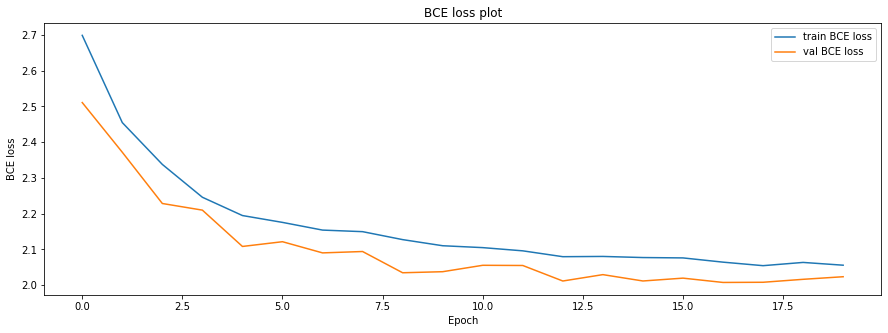

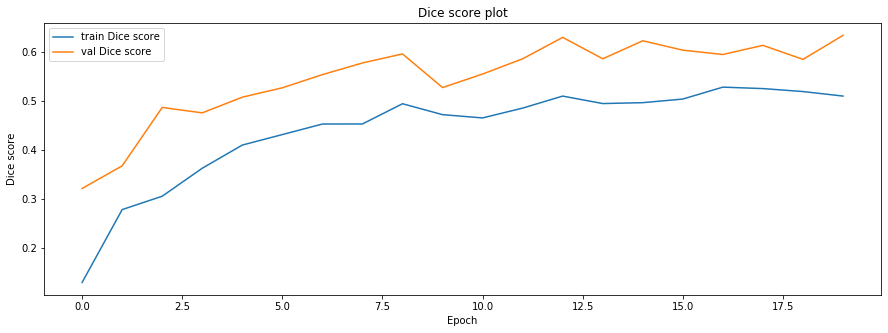

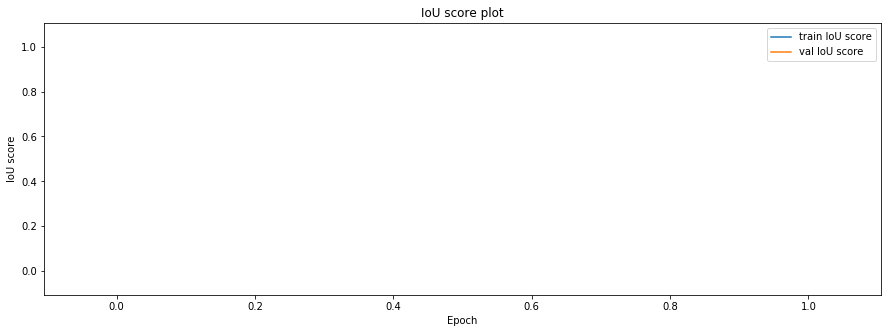

In [13]:
# PLOT TRAINING
losses = model_trainer.losses
dice_scores = model_trainer.dice_scores # overall dice
iou_scores = model_trainer.iou_scores

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

plot(losses, "BCE loss")
plot(dice_scores, "Dice score")
plot(iou_scores, "IoU score")

## Test prediction and submission

This training and validation takes about ~400 minutes which exceeds Kaggle's GPU usage limit of 60 minutes, we won't be able to submit the `submission.csv` file generated from this kernel. So, for test prediction and submission I've written a separate [UNet inference kernel](https://www.kaggle.com/rishabhiitbhu/unet-pytorch-inference-kernel), make sure you add the `model.pth` file generated from this kernel as dataset to test inference kernel.

I've used resnet-18 architecture in this kernel. It scores ~0.89 on LB. Try to play around with other architectures of `segmenation_models.pytorch` and see what works best for you, let me know in the comments :) and do upvote if you liked this kernel, I need some medals too. 😬

## Refrences:

Few kernels from which I've borrowed some cod[](http://)e:

* https://www.kaggle.com/amanooo/defect-detection-starter-u-net
* https://www.kaggle.com/go1dfish/clear-mask-visualization-and-simple-eda

A big thank you to all those who share their code on Kaggle, I'm nobody without you guys. I've learnt a lot from fellow kagglers, special shout-out to [@Abhishek](https://www.kaggle.com/abhishek), [@Yury](https://www.kaggle.com/deyury), [@Heng](https://www.kaggle.com/hengck23), [@Ekhtiar](https://www.kaggle.com/ekhtiar), [@lafoss](https://www.kaggle.com/iafoss), [@Siddhartha](https://www.kaggle.com/meaninglesslives), [@xhulu](https://www.kaggle.com/xhlulu), and the list goes on..